In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, get_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasClassifier





In [2]:
df = pd.read_csv(r"..\..\oblig3_og_4\student_performance.csv", delimiter=";")

In [3]:
targets = pd.Series(np.array(LabelEncoder().fit_transform(df['Target'])))
features = pd.DataFrame(StandardScaler().fit_transform(df.drop('Target', axis=1)), columns=df.drop('Target', axis=1).columns)

In [4]:
global_random_state = 15

scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'),
    #'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', response_method='predict')   
}

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='f1', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def print_estimators(estimators):
    for estimatior in estimators:
        print(estimatior)


In [5]:
def create_model(optimizer="adam", loss='sparse_categorical_crossentropy', activation='relu', hidden_neurons1=144, hidden_neurons2=72):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [6]:
keras_class_param = {
    'batch_size': [20],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [72],      
    'model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'model__activation': ['relu', 'tanh', 'elu', 'swish'],
}
keras_class_model = KerasClassifier(model=create_model, verbose=0)
keras_estimators, keras_scores_train, keras_scores_test, keras_cv_results = train(features, targets, keras_class_model, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

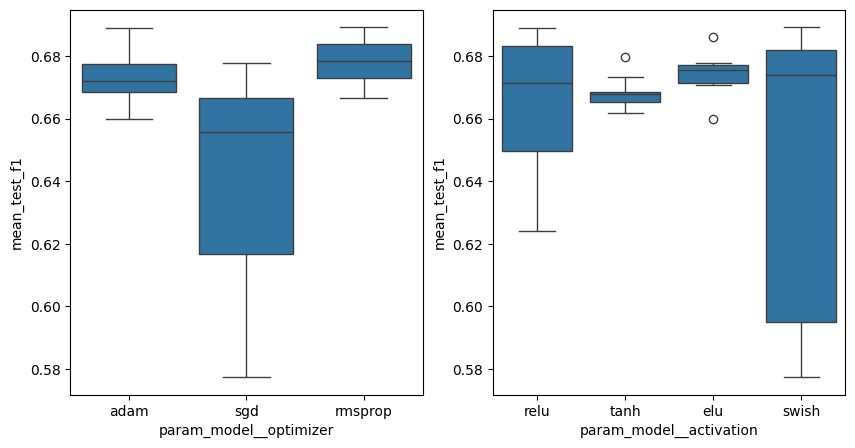

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results, x='param_model__optimizer', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results, x='param_model__activation', y='mean_test_f1', ax=ax[1])


In [8]:
keras_scores_test

,accuracy,precision,recall,f1
0,0.752542,0.703524,0.686342,0.692640
1,0.747797,0.662384,0.651111,0.648071
2,0.750339,0.692620,0.658945,0.669075


In [10]:
keras_scores_train

,accuracy,precision,recall,f1
0,0.820617,0.789582,0.763079,0.773473
1,0.858596,0.839843,0.795089,0.809141
2,0.824407,0.803388,0.755016,0.772103


In [12]:
keras_estimators

[KerasClassifier(
 	model=<function create_model at 0x00000116AF1F3880>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x00000116AF1F3880>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=relu
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x00000116AF1F3880>
 	build_fn=None
 	warm_st

In [ ]:
keras_class_param = {
    'batch_size': [20],
    'epochs': [10],
    'model__hidden_neurons1': [108, 144, 180],
    'model__hidden_neurons2': [72],      
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'elu', 'swish'],
}
keras_class_model_2 = KerasClassifier(model=create_model, verbose=0)
keras_estimators_2, keras_scores_train_2, keras_scores_test_2, keras_cv_results_2 = train(features, targets, keras_class_model_2, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

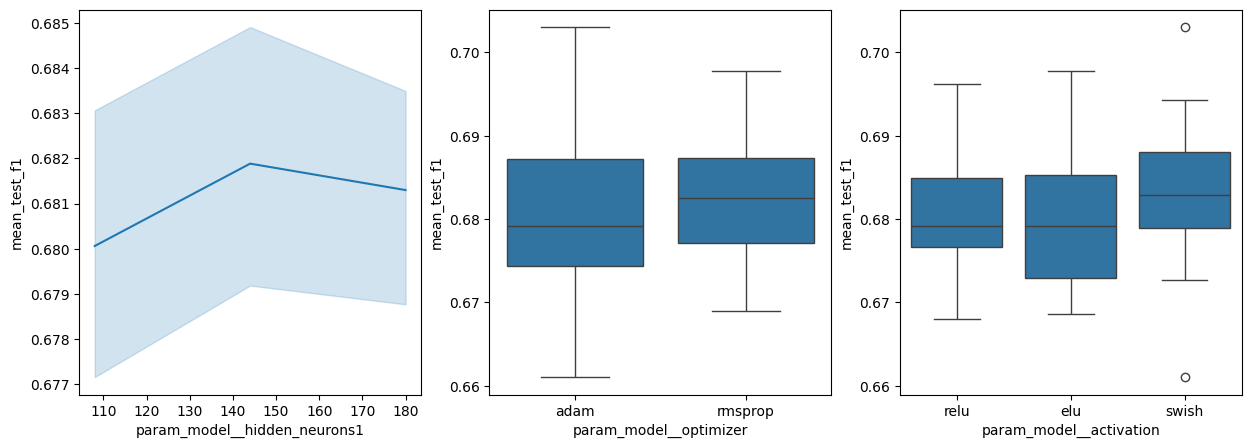

In [14]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=keras_cv_results_2, x='param_model__hidden_neurons1', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_2, x='param_model__optimizer', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=keras_cv_results_2, x='param_model__activation', y='mean_test_f1', ax=ax[2])

In [15]:
keras_scores_test_2

,accuracy,precision,recall,f1
0,0.758192,0.723896,0.696644,0.703491
1,0.733333,0.671755,0.657332,0.662852
2,0.748023,0.705233,0.697756,0.697265
3,0.780791,0.731047,0.712162,0.719490
4,0.755656,0.702006,0.662432,0.673759


In [16]:
keras_scores_train_2

,accuracy,precision,recall,f1
0,0.843176,0.826118,0.799155,0.806935
1,0.820571,0.785193,0.760028,0.770161
2,0.865216,0.841577,0.836232,0.836900
3,0.816615,0.772999,0.749029,0.758070
4,0.857345,0.849911,0.801250,0.819415


In [18]:
keras_estimators_2

[KerasClassifier(
 	model=<function create_model at 0x00000116AF1F3880>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=relu
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_model at 0x00000116AF1F3880>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_model at 0x00000116AF1F3880>
 	build_fn=None
 	warm_start=Fa

In [19]:
keras_class_param = {
    'batch_size': [20],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36, 72, 108],      
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu','swish'],
}
keras_estimators_3, keras_scores_train_3, keras_scores_test_3, keras_cv_results_3 = train(features, targets, keras_class_model, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

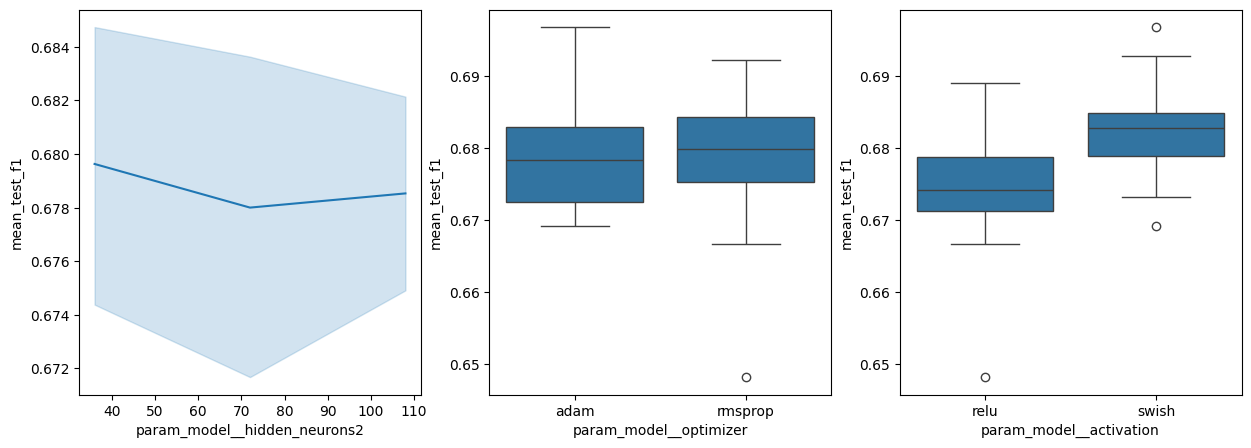

In [20]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=keras_cv_results_3, x='param_model__hidden_neurons2', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_3, x='param_model__optimizer', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=keras_cv_results_3, x='param_model__activation', y='mean_test_f1', ax=ax[2])

In [22]:
keras_scores_test_3

,accuracy,precision,recall,f1
0,0.762034,0.703904,0.678512,0.685778
1,0.757288,0.698368,0.679975,0.686376
2,0.768657,0.713254,0.679381,0.688377


In [21]:
keras_scores_train_3

,accuracy,precision,recall,f1
0,0.834520,0.806424,0.771122,0.784326
1,0.826043,0.796145,0.763175,0.775627
2,0.821695,0.796458,0.743498,0.759786


In [24]:
keras_estimators_3

[KerasClassifier(
 	model=<function create_model at 0x00000116AF1F3880>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_model at 0x00000116AF1F3880>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=108
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x00000116AF1F3880>
 	build_fn=None
 	warm_sta

In [28]:
def create_model_2(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=72, learing_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learing_rate), loss=loss, metrics=['accuracy'])
    return model

In [56]:
keras_class_param = {
    'batch_size': [10, 20, 30],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__learing_rate': [0.0001, 0.0005, 0.0008, 0.001],
}
keras_class_model_3 = KerasClassifier(model=create_model_2, verbose=0)
keras_estimators_4, keras_scores_train_4, keras_scores_test_4, keras_cv_results_4 = train(features, targets, keras_class_model_3, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__learing_rate', ylabel='mean_test_f1'>

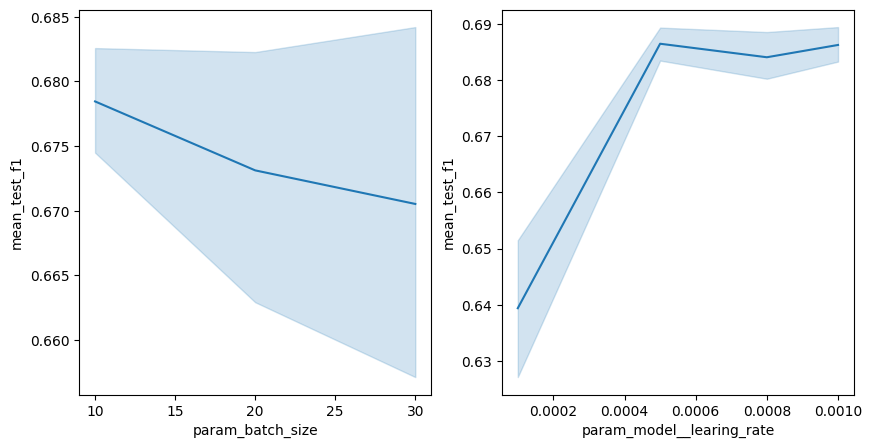

In [57]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_cv_results_4, x='param_batch_size', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_4, x='param_model__learing_rate', y='mean_test_f1', ax=ax[1])


In [58]:
keras_scores_test_4

,accuracy,precision,recall,f1
0,0.768362,0.714544,0.679249,0.688106
1,0.749153,0.685853,0.663948,0.670259
2,0.764972,0.697772,0.678952,0.684306
3,0.783051,0.736211,0.701087,0.711396
4,0.761312,0.708045,0.670076,0.681345


In [59]:
keras_scores_train_4

,accuracy,precision,recall,f1
0,0.820288,0.788529,0.742697,0.757285
1,0.819158,0.781174,0.748791,0.760312
2,0.804747,0.767240,0.727786,0.741299
3,0.797118,0.751544,0.716204,0.726881
4,0.818644,0.793163,0.745977,0.762388


In [61]:
keras_estimators_4

[KerasClassifier(
 	model=<function create_model_2 at 0x000001176DB1F100>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.001
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x000001176DB1F100>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=30
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.001
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x000001176DB1F100>
 	build_fn=None


In [67]:
keras_class_param = {
    'batch_size': [5, 10],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__learing_rate': [0.0005, 0.001, 0.0025, 0.005],
}
keras_estimators_5, keras_scores_train_5, keras_scores_test_5, keras_cv_results_5 = train(features, targets, keras_class_model_3, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__learing_rate', ylabel='mean_test_f1'>

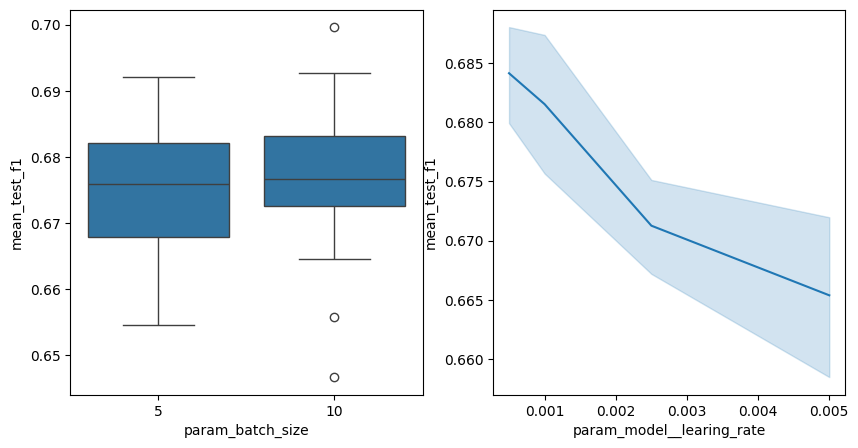

In [68]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results_5, x='param_batch_size', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_5, x='param_model__learing_rate', y='mean_test_f1', ax=ax[1])

In [70]:
keras_scores_test_5

,accuracy,precision,recall,f1
0,0.754802,0.695133,0.667995,0.676376
1,0.753672,0.702765,0.682064,0.689657
2,0.764972,0.706091,0.695563,0.699962
3,0.783051,0.729329,0.703435,0.712379
4,0.769231,0.716512,0.682552,0.693331


In [71]:
keras_scores_train_5

,accuracy,precision,recall,f1
0,0.838372,0.815040,0.779006,0.793106
1,0.836394,0.808837,0.777504,0.789945
2,0.818028,0.782501,0.765260,0.772138
3,0.825940,0.791973,0.756959,0.769649
4,0.830226,0.801757,0.772009,0.783788


In [73]:
keras_estimators_5

[KerasClassifier(
 	model=<function create_model_2 at 0x000001176DB1F100>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.001
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x000001176DB1F100>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.001
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x000001176DB1F100>
 	build_fn=None


input = Input(shape=(28,28,1))
flatten = Flatten()
dense1 = Dense(380)(flatten)
dense2 = Dense(180)(dense1) + Dense(180)(flatten)
output = Dense(10, activation='softmax')

model = tf.keras.models.Model(input=input, outputs=output)